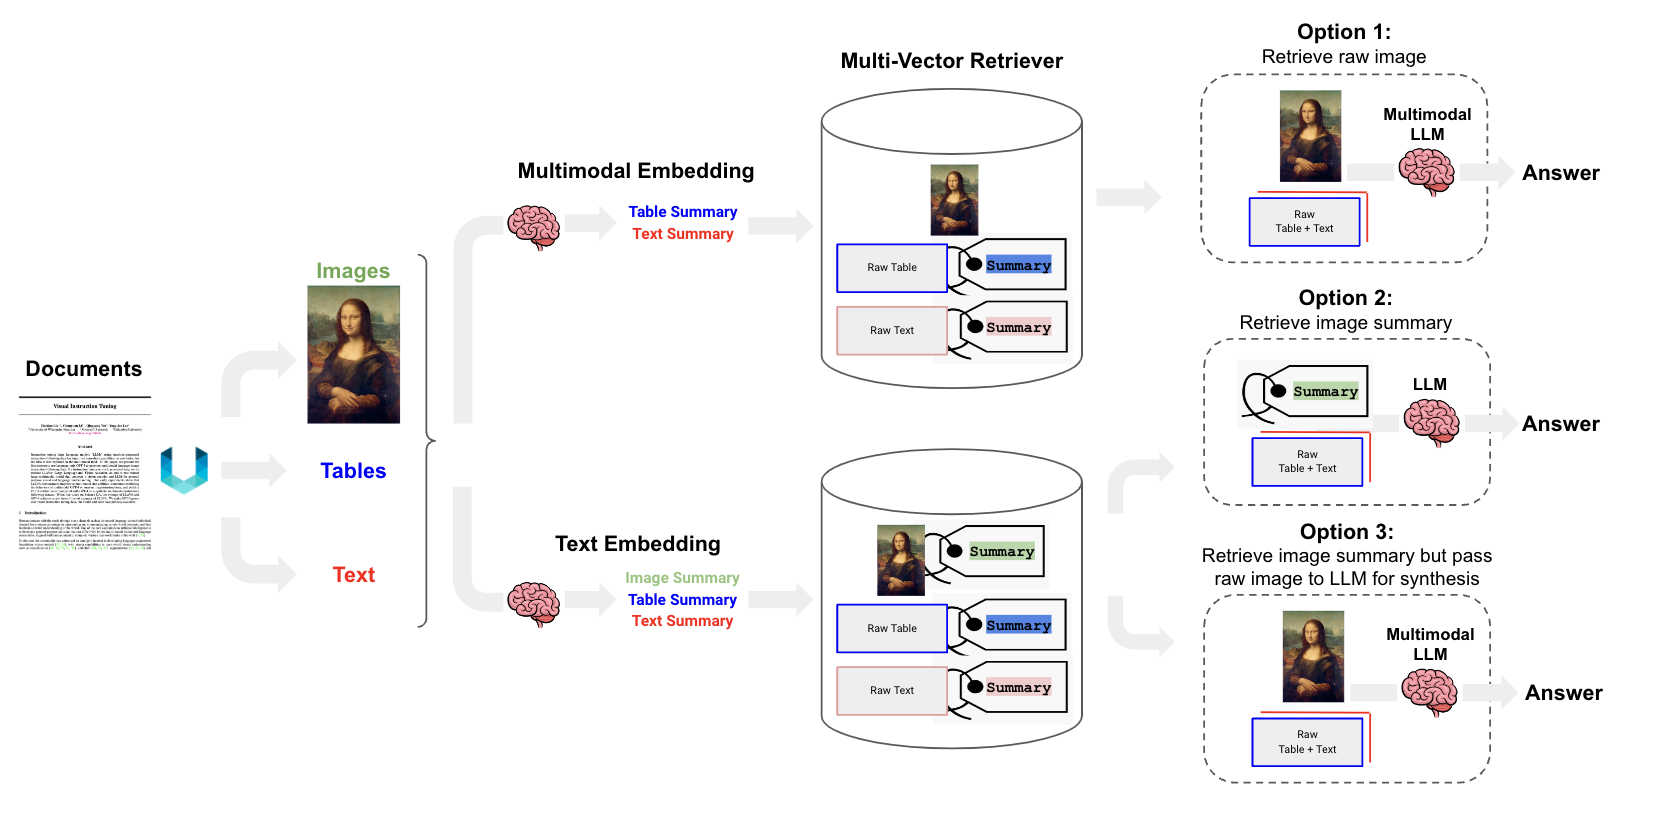

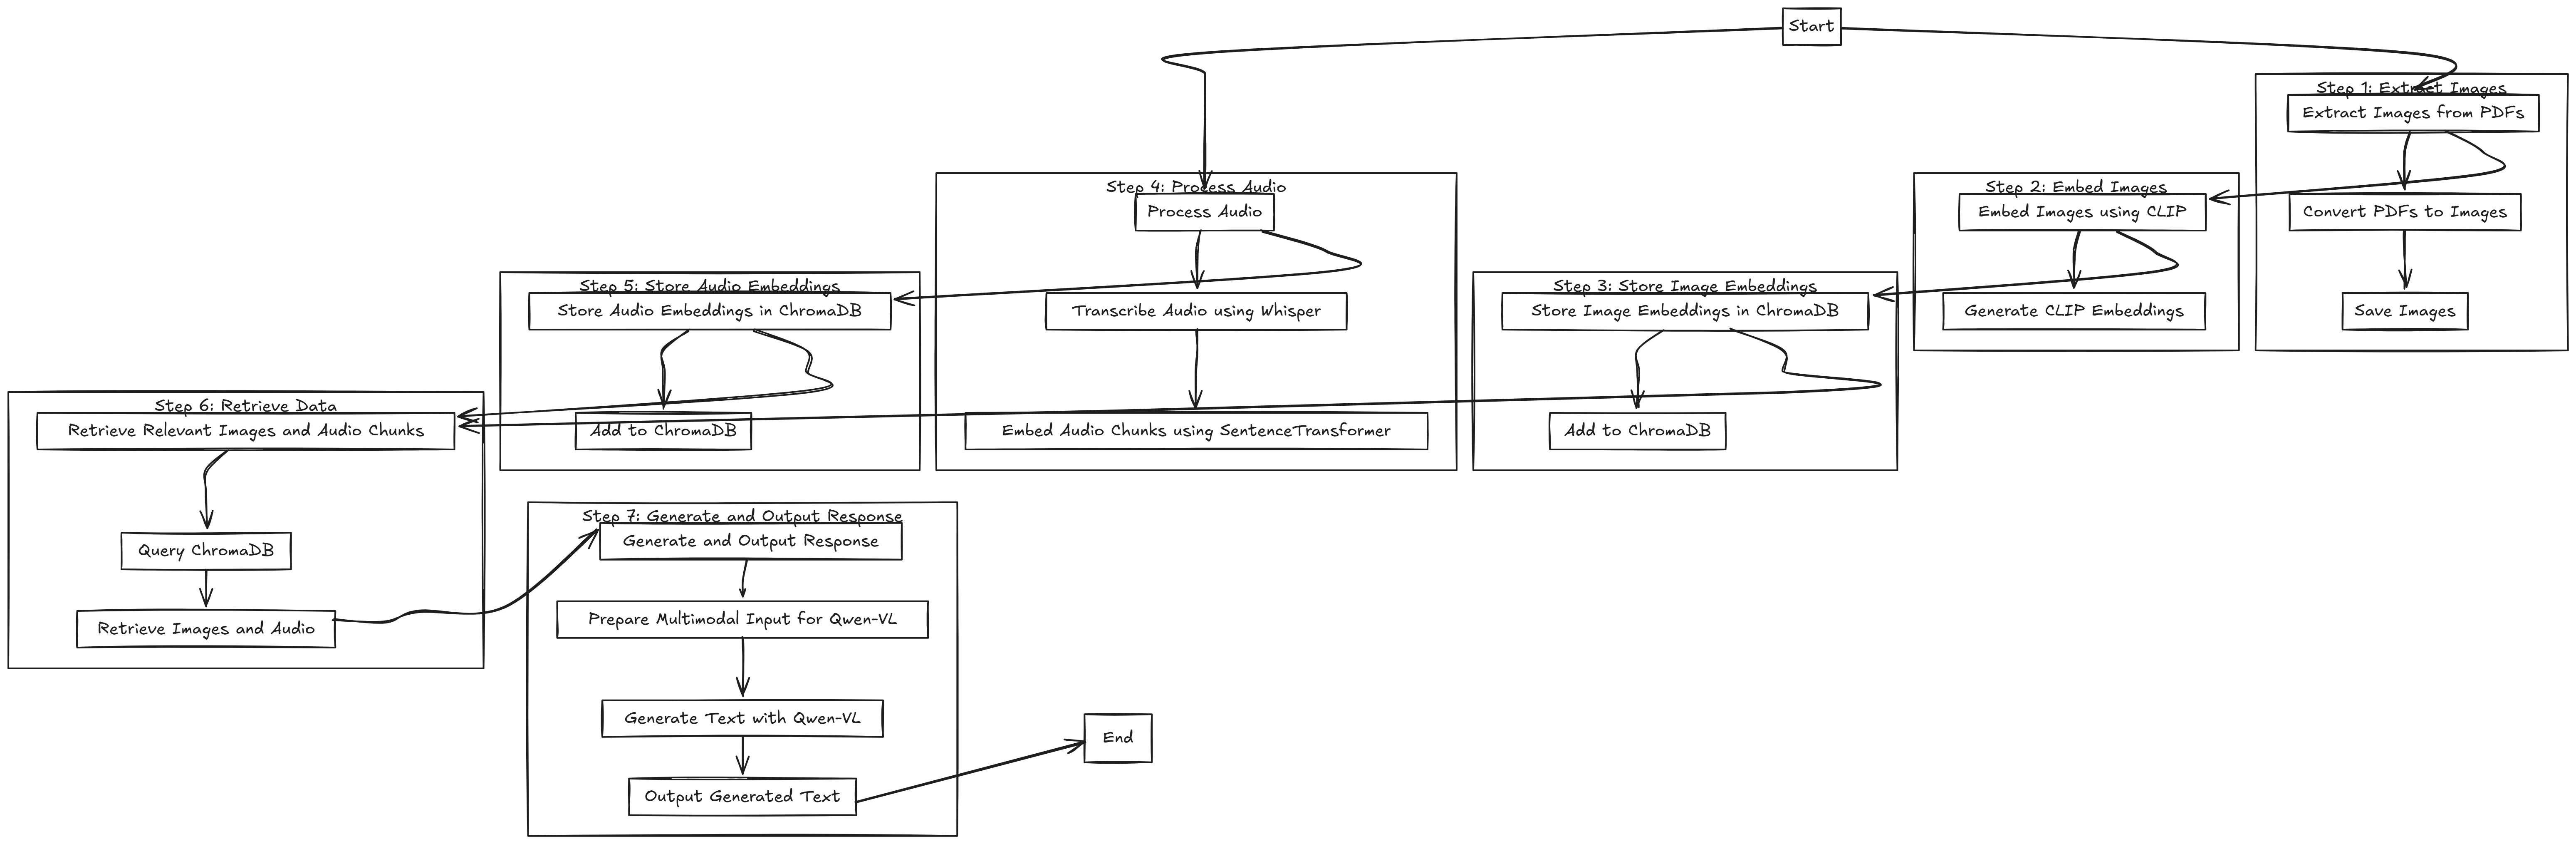

In [1]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import trafilatura

def scrape_website(url):
    """
    Scrape text, image URLs, audio URLs, and tables from a website
    Returns: (text_content, image_urls, audio_urls, tables)
    """
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract main text content using trafilatura
        downloaded = trafilatura.fetch_url(url)
        text_content = trafilatura.extract(downloaded, include_links=True)
        if text_content is None:
            text_content = soup.get_text(separator=' ', strip=True)
            
        # Extract image URLs
        image_urls = []
        for img in soup.find_all('img'):
            src = img.get('src')
            if src:
                absolute_url = urljoin(url, src)
                if absolute_url.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.webp')):
                    image_urls.append(absolute_url)
        
        # Extract audio URLs
        audio_urls = []
        audio_tags = soup.find_all(['audio', 'a'])
        for tag in audio_tags:
            if tag.name == 'audio':
                sources = tag.find_all('source')
                for source in sources:
                    src = source.get('src')
                    if src:
                        absolute_url = urljoin(url, src)
                        if absolute_url.lower().endswith(('.mp3', '.wav', '.ogg', '.m4a')):
                            audio_urls.append(absolute_url)
            elif tag.name == 'a':
                href = tag.get('href')
                if href:
                    absolute_url = urljoin(url, href)
                    if absolute_url.lower().endswith(('.mp3', '.wav', '.ogg', '.m4a')):
                        audio_urls.append(absolute_url)
        
        # Extract tables
        tables = []
        for table in soup.find_all('table'):
            # Extract table data into a list of dictionaries
            table_data = []
            headers = []
            
            # Get headers (th cells)
            header_row = table.find('tr')
            if header_row:
                for th in header_row.find_all(['th', 'td']):
                    headers.append(th.get_text(strip=True))
            
            # Get table rows
            for row in table.find_all('tr')[1:]:  # Skip header row if we found one
                cells = row.find_all(['td', 'th'])
                if cells:
                    row_data = {}
                    for i, cell in enumerate(cells):
                        header = headers[i] if i < len(headers) else f'Column_{i}'
                        row_data[header] = cell.get_text(strip=True)
                    table_data.append(row_data)
            
            if table_data:
                tables.append(table_data)
        
        return text_content, image_urls, audio_urls, tables
    
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return None, [], [], []

In [3]:
url = "https://www.geeksforgeeks.org/computer-vision/?utm_source=geeksforgeeks&utm_medium=gfgcontent_shm&utm_campaign=shm"
text_content, image_urls, audio_urls, tables = scrape_website(url)
print("Text Content:", text_content[:200], "...")

print("lenght of text files found:", len(text_content))


print("Image URLs:", image_urls)
print("Number of images found:", len(image_urls))
print("Audio URLs:", audio_urls)
print("Tables:", tables)

Text Content: Computer Vision is a branch of Artificial Intelligence (AI) that enables computers to interpret and extract information from images and videos, similar to human perception. It involves developing algo ...
lenght of text files found: 13755
Image URLs: ['https://media.geeksforgeeks.org/wp-content/uploads/20250130182819321724/24.webp', 'https://media.geeksforgeeks.org/wp-content/uploads/20230711133753/Computer-Vision-Tutorial.webp', 'https://media.geeksforgeeks.org/wp-content/uploads/20200717172614/authPreLogo.png', 'https://media.geeksforgeeks.org/img-practice/prod/courses/504/Mobile/Other/Course_DSA_to_Dev_1720846081.webp', 'https://media.geeksforgeeks.org/img-practice/prod/courses/405/Mobile/Other/Course_ML_&_DS_1720846555.webp', 'https://media.geeksforgeeks.org/img-practice/prod/courses/740/Web/Content/emb_1723090730.webp', 'https://media.geeksforgeeks.org/auth-dashboard-uploads/gfgFooterLogo.png', 'https://media.geeksforgeeks.org/auth-dashboard-uploads/googleplay.png', 

In [42]:
text_content = preprocess_text(text_content)
print("Preprocessed Text Content:", text_content[:200], "...")

Preprocessed Text Content: computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful in ...


In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import Ollama

def generate_text_summaries(texts, tables, summarize_texts=False, model_name="mistral:latest"):
    """
    Summarize text elements using local Ollama models
    
    Args:
        texts: List of strings to summarize
        tables: List of table data strings
        summarize_texts: Whether to summarize texts (False returns originals)
        model_name: Which Ollama model to use ('deepseek-r1:14b' or 'mistral')
    
    Returns:
        tuple: (text_summaries, table_summaries)
    """
    # Initialize Ollama with your local model
    llm = Ollama(
        model=model_name,
        temperature=0.3,
        top_p=0.9,
        num_ctx=2048  # Context window size
    )
    
    # Optimized prompt for local models
    prompt_text = """[INST] <<SYS>>
    You are an AI assistant that creates concise, retrieval-optimized summaries.
    Keep summaries under 3 sentences while preserving key information.
    <</SYS>>
    
    Summarize this content for embedding-based retrieval:
    {element} [/INST]"""
    
    prompt = ChatPromptTemplate.from_template(prompt_text)
    summarize_chain = {"element": lambda x: x} | prompt | llm | StrOutputParser()

    # Process texts (conditionally summarize)
    text_summaries = texts
    if summarize_texts and texts:
        text_summaries = []
        for text in texts:
            # Batch processing with error handling
            try:
                summary = summarize_chain.invoke(text)
                text_summaries.append(summary)
            except Exception as e:
                print(f"Error summarizing text: {str(e)}")
                text_summaries.append(text[:500] + "...")  # Fallback

    # Process tables
    table_summaries = []
    if tables:
        for table in tables:
            try:
                summary = summarize_chain.invoke(f"TABLE DATA:\n{table}")
                table_summaries.append(summary)
            except Exception as e:
                print(f"Error summarizing table: {str(e)}")
                table_summaries.append(table)

    return text_summaries, table_summaries

In [32]:
text_content , table_summaries = generate_text_summaries(text_content, tables, summarize_texts=False)

In [35]:
print("Table Summaries:", table_summaries[:100], "...")
print("table summaries length:", len(table_summaries[0]))

Table Summaries: ['1. From 2010 to 2015: Development of deep learning algorithms for image recognition, introduction of convolutional neural networks (CNNs) for image classification, use of computer vision in autonomous vehicles, and advancements in real-time object detection with systems like YOLO.\n\n2. From 2015 to 2020: Advancements in facial recognition technology, integration of computer vision in augmented reality (AR) and virtual reality (VR) systems, use in medical imaging for disease diagnosis, and its application in unlocking smartphones and surveillance.\n\n3. Predicted evolution from 2020 to 2025: Further advancements in real-time object detection and image recognition, increased use of computer vision in healthcare for early disease detection and treatment, integration in more consumer products like smart home devices, and sophisticated use in autonomous vehicles.'] ...
table summaries length: 867


In [49]:
import re
import string
import spacy
from nltk.corpus import stopwords

# Load spaCy model and stop words
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Custom unwanted words/phrases typical in web-scraped UI content
custom_unwanted_phrases = [
    "login", "sign up", "signup", "create account", "forgot password", 
    "click here", "read more", "terms of service", "privacy policy",
    "subscribe", "register", "next page", "previous page", "contact us",
    "about us", "home", "back to top", "follow us", "view more"
]

def preprocess_text(text):
    """
    Clean and preprocess text content, removing web-scraped UI junk and <think> tags.
    """
    if not text:
        return ""

    # Remove all content within <think>...</think> tags
    text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)

    # Remove newline characters and extra whitespace
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove unwanted phrases
    for phrase in custom_unwanted_phrases:
        text = text.replace(phrase, '')

    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Extra space cleanup
    text = re.sub(r'\s+', ' ', text).strip()

    # Lemmatize and remove stopwords + punctuation
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc 
        if token.text not in stop_words 
        and token.text not in string.punctuation
        and token.lemma_ not in custom_unwanted_phrases
    ]

    return ' '.join(tokens)


Preprocessed Text Content: computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful in ...


In [45]:
from langchain_community.llms import Ollama
from PIL import Image
import pytesseract
import requests
from io import BytesIO
import subprocess
import torch

def generate_summaries(
    texts=None, 
    tables=None, 
    image_urls=None,  # Now accepts URLs instead of local paths
    model_name="deepseek-r1:14b",
    summarize_texts=False
):
    """
    Summarizes text, tables, images (from URLs), and audio.
    Automatically stops Ollama afterward.

    Args:
        texts (list): List of text strings.
        tables (list): List of table data strings.
        image_urls (list): List of image URLs (PNG/JPG).
        audio_paths (list): List of audio file paths (MP3/WAV).
        model_name (str): Ollama model name (e.g., "deepseek-r1:14b").
        summarize_texts (bool): Whether to summarize plain text.

    Returns:
        dict: {
            "text_summaries": [...],
            "table_summaries": [...],
            "image_summaries": [...],
            "audio_summaries": [...]
        }
    """
    llm = Ollama(model=model_name, temperature=0.3)
    prompt = ChatPromptTemplate.from_template("[INST] Summarize: {element} [/INST]")
    summarize_chain = {"element": lambda x: x} | prompt | llm | StrOutputParser()

    summaries = {
        "text_summaries": texts if not summarize_texts else [],
        "table_summaries": [],
        "image_summaries": []
        # "audio_summaries": []
    }

    # === 1. Text Summarization ===
    if summarize_texts and texts:
        summaries["text_summaries"] = summarize_chain.batch(texts)

    # === 2. Table Summarization ===
    if tables:
        summaries["table_summaries"] = summarize_chain.batch(
            [f"TABLE DATA:\n{table}" for table in tables]
        )

    # === 3. Image Summarization (Download + OCR) ===
    if image_urls:
        for url in image_urls:
            try:
                # Download the image
                response = requests.get(url, timeout=10)
                response.raise_for_status()  # Check for HTTP errors
                img = Image.open(BytesIO(response.content))
                
                # Extract text using OCR
                text = pytesseract.image_to_string(img)
                summary = summarize_chain.invoke(f"IMAGE CONTENT:\n{text}")
                summaries["image_summaries"].append(summary)
            except Exception as e:
                print(f"Error processing image URL {url}: {e}")
                summaries["image_summaries"].append("(Image processing failed)")

    # # === 4. Audio Summarization (Unchanged) ===
    # if audio_paths:
    #     recognizer = sr.Recognizer()
    #     for audio_path in audio_paths:
    #         try:
    #             audio = AudioSegment.from_file(audio_path)
    #             wav_path = "temp.wav"
    #             audio.export(wav_path, format="wav")
    #             with sr.AudioFile(wav_path) as source:
    #                 audio_data = recognizer.record(source)
    #                 transcript = recognizer.recognize_google(audio_data)
    #             summary = summarize_chain.invoke(f"AUDIO TRANSCRIPT:\n{transcript}")
    #             summaries["audio_summaries"].append(summary)
    #         except Exception as e:
    #             print(f"Error processing audio {audio_path}: {e}")
    #             summaries["audio_summaries"].append("(Audio processing failed)")

    # === STOP THE MODEL ===
    # try:
    #     subprocess.run(["pkill", "-f", "ollama"], check=True)  # Linux/macOS
    #     if torch.cuda.is_available():
    #         torch.cuda.empty_cache()
    # except Exception as e:
    #     print(f"Error stopping model: {e}")

    return summaries

In [46]:
summaries = generate_summaries(text_content, tables, image_urls, summarize_texts=False)


In [51]:
summaries["table_summaries"] = [preprocess_text(table) for table in summaries["table_summaries"]]
summaries["text_summaries"] = preprocess_text(summaries["text_summaries"])
summaries["image_summaries"] = [preprocess_text(image) for image in summaries["image_summaries"]]

In [54]:
import json

# Load the summaries back from the JSON file
with open("summaries.json", "r") as json_file:
    loaded_summaries = json.load(json_file)

print("Loaded Summaries:", loaded_summaries)

Loaded Summaries: {'text_summaries': 'computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diagnostic agriculture manufacturing automate visual task solve real world problem enhance public safety improve medical imaging optimize industrial process application computer vision computer vision tutorial design beginner experience professional cover key concept computer vision include image processing feature extraction object detection recognition image segmentation diving computer vision recommend foundational understanding machine learn deep learn opencv resource help build necessary background understanding implement computer vision

In [107]:
summaries

{'text_summaries': 'computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diagnostic agriculture manufacturing automate visual task solve real world problem enhance public safety improve medical imaging optimize industrial process application computer vision computer vision tutorial design beginner experience professional cover key concept computer vision include image processing feature extraction object detection recognition image segmentation diving computer vision recommend foundational understanding machine learn deep learn opencv resource help build necessary background understanding implement computer vision technique effecti

In [52]:
print("Text Summaries:", summaries["text_summaries"][:2])
print("Table Summaries:", summaries["table_summaries"][:2])
print("Image Summaries:", summaries["image_summaries"][:2])
print("Number of text summaries:", len(summaries["text_summaries"]))
print("Number of table summaries:", len(summaries["table_summaries"]))
print("Number of image summaries:", len(summaries["image_summaries"]))
print("Number of images:", len(image_urls))
print("Number of tables:", len(tables))

Text Summaries: co
Table Summaries: ['evolution computer vision see significant advancement across three key period era mark foundational development deep learning algorithm enhance image recognition introduction cnn classification autonomous vehicle begin utilize cv object detection navigation innovation include real time object detection system like yolo expand facial recognition device surveillance integration ar vr medical application disease diagnosis predict anticipate advancement include enhance object detection deep cv integration autonomous vehicle expand healthcare use early disease management broad consumer product application like smart']
Image Summaries: ['image content outline three key technology intruder detection system monitor unauthorized access character reader ocr technology use convert image text editable format computer vision combine robotic bin picking automate handling item disorganized setting', 'image content relate computer vision involve teach machine inte

In [68]:

from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=250,
    length_function=len,
    add_start_index=True,
)

In [69]:
context_split = text_splitter.create_documents([text_content])
print("Number of chunks created:", len(context_split))
print("First chunk:", context_split[0].page_content)
print("First chunk metadata:", context_split[0].metadata)
chunks = text_splitter.split_text(text_content)
print(chunks[:5])

Number of chunks created: 33
First chunk: computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diagnostic agriculture manufacturing automate visual task solve real world problem
First chunk metadata: {'start_index': 0}
['computer vision branch artificial intelligence ai enable computer interpret extract information image video similar human perception involve develop algorithm process visual datum derive meaningful insight learn computer vision high demand job market essential career ai machine learn datum science across industry like healthcare automotive robotic revolutionize industry power advancement self drive car medical diag

In [108]:
summaries["image_summaries"][0]

'image content outline three key technology intruder detection system monitor unauthorized access character reader ocr technology use convert image text editable format computer vision combine robotic bin picking automate handling item disorganized setting'

In [139]:
import uuid
from typing import List, Dict
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser

class WebOwlRAGSystem:
    def __init__(self, texts: List[str], text_summaries: List[str],
                 tables: List[str], table_summaries: List[str],
                 images: List[str], image_summaries: List[str],
                 llm):
        """
        Initialize with all content types and their summaries
        """
        self.llm = llm
        self.vectorstore = Chroma(
            collection_name="webowl_rag",
            embedding_function=OpenAIEmbeddings()
        )
        
        # Create retriever
        self.retriever = self._create_multi_vector_retriever(
            texts, text_summaries,
            tables, table_summaries,
            images, image_summaries
        )
        
        # Setup LLM chain
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """
            You are WebOwl, a precise research assistant. Rules:
            1. ANSWER ONLY USING THESE CONTEXTS
            2. Present information in this order:
               a) Direct answer to question
               b) Supporting text evidence
               c) Relevant tables (show full table)
               d) Image references
            3. Never invent information
            4. Mark sources clearly with:
               - 📄 Text | 📊 Table | 🖼️ Image
            
            Contexts:
            {context}
            """),
            ("human", "{question}"),
        ])
        
        self.chain = (
            {"context": self._retrieve_context, "question": RunnablePassthrough()}
            | self.prompt
            | self.llm
            | StrOutputParser()
        )
    
    def _create_multi_vector_retriever(self, texts, text_summaries,
                                     tables, table_summaries,
                                     images, image_summaries):
        """Create MultiVectorRetriever with proper indexing"""
        store = InMemoryStore()
        id_key = "doc_id"
        
        retriever = MultiVectorRetriever(
            vectorstore=self.vectorstore,
            docstore=store,
            id_key=id_key,
        )
        
        # Helper to add documents
        def add_docs(summaries, contents, content_type):
            if not summaries:
                return
                
            doc_ids = [str(uuid.uuid4()) for _ in contents]
            
            # Create summary documents
            summary_docs = []
            for i, s in enumerate(summaries):
                if isinstance(s, dict):
                    # Convert dict to string if needed
                    s = str(s)
                summary_docs.append(
                    Document(
                        page_content=s,
                        metadata={
                            id_key: doc_ids[i],
                            "type": content_type,
                            "original_id": doc_ids[i]
                        }
                    )
                )
            retriever.vectorstore.add_documents(summary_docs)
            
            # Store original content
            content_pairs = []
            for i, c in enumerate(contents):
                if isinstance(c, dict):
                    # Convert dict to string if needed
                    c = str(c)
                content_pairs.append((doc_ids[i], c))
            
            retriever.docstore.mset(content_pairs)
        
        # Add all content types
        add_docs(text_summaries, texts, "text")
        add_docs(table_summaries, tables, "table")
        add_docs(image_summaries, images, "image")
        
        return retriever
    
    def _retrieve_context(self, question: str) -> str:
        """Retrieve and format all relevant contexts"""
        docs = self.retriever.get_relevant_documents(question)
        if not docs:
            return "No relevant contexts found."
        
        # Organize by type
        context = {"text": [], "table": [], "image": []}
        for doc in docs:
            doc_type = doc.metadata.get("type")
            if doc_type in context:
                context[doc_type].append(doc)
        
        # Format response
        parts = []
        if context["text"]:
            parts.append("📄 TEXT CONTEXTS:")
            parts.extend([doc.page_content for doc in context["text"]])
        
        if context["table"]:
            parts.append("\n📊 TABLES:")
            parts.extend([doc.page_content for doc in context["table"]])
        
        if context["image"]:
            parts.append("\n🖼️ IMAGE REFERENCES:")
            parts.extend([
                f"{doc.page_content} (ID: {doc.metadata['original_id']})"
                for doc in context["image"]
            ])
        
        return "\n".join(parts)
    
    def query(self, question: str) -> str:
        """Execute a query with proper context handling"""
        try:
            if not question.strip():
                return "🦉 Error: Empty query received"
                
            response = self.chain.invoke(question)
            
            if not response:
                raise ValueError("No response generated")
            
            return f"🦉 WebOwl Analysis:\n\n{response}"
            
        except Exception as e:
            return f"🦉 Error: {str(e)}"

ModuleNotFoundError: No module named 'langchain_chroma'

In [140]:
webowl = WebOwlRAGSystem(
    texts=chunks,
    text_summaries=chunks,
    tables=tables,
    table_summaries=summaries["table_summaries"],
    images=image_urls,
    image_summaries=summaries["image_summaries"]
)

ValidationError: 1 validation error for Document
page_content
  Input should be a valid string [type=string_type, input_value=[{'Time Period': '2010-20...e smart home devices.'}], input_type=list]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type

In [134]:
response = webowl.query(query)

NameError: name 'webowl' is not defined

In [124]:
# 8. Test Query

result = qa_chain(query)

# 9. Output
print("Answer:", result['result'])
print("\nSources:")
for doc in result['source_documents']:
    print(doc.metadata, doc.page_content)

Answer: 1. The article focuses on the concept of sustainable urbanization and its importance in addressing global challenges like climate change and inequality.
2. It highlights how sustainable urbanization can be achieved by creating compact, connected, and coordinated cities with efficient infrastructure, mixed-use development, and a focus on public transportation.
3. The piece emphasizes the need for green buildings and energy-efficient technologies in cities to reduce carbon emissions and promote renewable energy sources.
4. It also discusses the importance of social equity in sustainable urbanization by ensuring affordable housing, access to quality education and healthcare, and job opportunities for all citizens.
5. The article concludes with a call to action, urging policymakers, urban planners, and communities to work together towards sustainable and inclusive urban development.

Sources:


In [83]:
from langchain.schema import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain.vectorstores import FAISS
from typing import List, Optional, Dict, Any

def create_multimodal_retriever(
    text_chunks: Optional[List[str]] = None,
    image_urls: Optional[List[str]] = None,
    image_summaries: Optional[List[str]] = None,
    tables: Optional[List[str]] = None,
    table_summaries: Optional[List[str]] = None,
    embed_model = None
) -> MultiVectorRetriever:
    """
    Creates a properly configured MultiVectorRetriever with correct metadata handling.
    Returns both the retriever and the original documents for reference.
    """
    # 1. Prepare all documents with metadata
    all_docs = []
    id_to_doc = {}  # Maps doc_id to original content
    
    # Helper function to create documents
    def create_doc(content: str, metadata: Dict[str, Any]) -> Document:
        doc = Document(page_content=content, metadata=metadata)
        id_to_doc[metadata["doc_id"]] = doc
        return doc
    
    # Text chunks
    if text_chunks:
        for i, text in enumerate(text_chunks):
            all_docs.append(create_doc(
                content=text,
                metadata={
                    "doc_id": f"text_{i}",
                    "type": "text",
                    "original_content": text
                }
            ))
    
    # Image documents
    if image_urls and image_summaries:
        for i, (url, summary) in enumerate(zip(image_urls, image_summaries)):
            all_docs.append(create_doc(
                content=summary,
                metadata={
                    "doc_id": f"image_{i}",
                    "type": "image",
                    "image_url": url,
                    "original_content": url
                }
            ))
    
    # Table documents
    if tables and table_summaries:
        for i, (table, summary) in enumerate(zip(tables, table_summaries)):
            all_docs.append(create_doc(
                content=summary,
                metadata={
                    "doc_id": f"table_{i}",
                    "type": "table",
                    "original_content": table,
                    "format": "markdown"
                }
            ))
    
    # 2. Initialize vector store and storage
    vectorstore = FAISS.from_documents(all_docs, embed_model)
    docstore = InMemoryStore()
    
    # 3. Build the retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=docstore,
        id_key="doc_id"
    )
    
    # Store documents in docstore
    retriever.docstore.mset([
        (doc_id, doc.metadata["original_content"])
        for doc_id, doc in id_to_doc.items()
    ])
    
    return retriever, all_docs

In [91]:
from torch import cuda
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

embed_model = HuggingFaceEmbeddings(
    model_name=embed_model_id,
    model_kwargs={'device': device},
    encode_kwargs={'device': device},
)
retriever, original_docs  = create_multimodal_retriever(text_chunks=chunks,image_urls=image_urls, image_summaries=summaries["image_summaries"], tables=tables, table_summaries=summaries["table_summaries"], embed_model=embed_model)

In [104]:
llm = Ollama(model="mistral:latest") 
webowl_chain = create_webowl_chain(retriever, llm)


In [105]:
webowl_chain("Why computer vision is important?")  # 


'🦉 Computer vision, my friend, is akin to the ability of an owl to spot its prey in the darkest forest. It\'s the superpower that allows machines to interpret and understand the visual world just like we do. Here\'s why it\'s important:\n\n📄 *Text Summary*:\n1. Enabling Autonomous Systems: Self-driving cars, drones, and robots rely on computer vision to navigate and avoid obstacles.\n2. Image Recognition & Analysis: From identifying objects in photos (like that adorable cat video you can\'t resist) to diagnosing diseases from medical images, CV is indispensable.\n3. Facial Recognition: Whether it\'s securing your phone with facial ID or managing access to buildings, computer vision ensures safety and convenience.\n4. Quality Control in Manufacturing: By automating the inspection process, CV helps maintain product quality and reduce costs.\n5. Augmented Reality (AR) & Virtual Reality (VR): The immersive experiences you enjoy in games or apps are made possible by computer vision.\n6. Env

In [106]:
webowl_chain("provide summary")


"🦉📝 *Hoot hoot! Summary Report* 📝🦉\n\n🖼️ *Visual References*:\n- seem like ask summary content provide image content could please provide image additional detail help summarize (🔗 https://media.geeksforgeeks.org/auth-dashboard-uploads/createImprovementIcon.png\n- provide accurate summary could please describe image detail include notable element color object people text let know specific aspect like emphasize (🔗 https://media.geeksforgeeks.org/wp-content/uploads/20200717172614/authPreLogo.png\n- unable summarize image actual image provide however describe image provide text happy help (🔗 https://media.geeksforgeeks.org/auth-dashboard-uploads/suggestChangeIcon.png\n\n🦉 *Synthesis*: 📄 In a nutshell, you've asked me to provide a comprehensive summary that combines all the information from text, images, and tables you've shared. Let's see if I can juggle these data modalities without dropping any balls (or pixels).\n\n🖼️ You've shown me an image of a majestic owl perched on a tree branch, 